In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class TextKMeansClassifier:
    def __init__(self, n_clusters=3, embedding_model='paraphrase-MiniLM-L6-v2', random_state=42):
        """
        Initialize the text k-means classifier.
        
        Args:
            n_clusters (int): Number of clusters (default: 3)
            embedding_model (str): Pre-trained sentence transformer model
            random_state (int): Random state for reproducibility
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.embedding_model_name = embedding_model
        
        # Initialize models
        self.sentence_model = SentenceTransformer(embedding_model)
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        
        # Storage for results
        self.embeddings = None
        self.labels = None
        self.texts = None
        
    def fit(self, texts):
        """
        Fit the k-means classifier on text data.
        
        Args:
            texts (list): List of text strings to cluster
            
        Returns:
            self: Returns the fitted classifier
        """
        self.texts = texts
        
        # Generate embeddings
        print("Generating embeddings...")
        self.embeddings = self.sentence_model.encode(texts, show_progress_bar=True)
        
        # Fit k-means
        print("Fitting k-means...")
        self.labels = self.kmeans.fit_predict(self.embeddings)
        
        return self
    
    def predict(self, texts):
        """
        Predict cluster labels for new texts.
        
        Args:
            texts (list): List of text strings to classify
            
        Returns:
            np.array: Predicted cluster labels
        """
        if self.kmeans is None:
            raise ValueError("Model must be fitted before prediction")
        
        # Generate embeddings for new texts
        new_embeddings = self.sentence_model.encode(texts)
        
        # Predict clusters
        return self.kmeans.predict(new_embeddings)
    
    def get_cluster_info(self):
        """
        Get information about the clusters.
        
        Returns:
            dict: Dictionary with cluster information
        """
        if self.labels is None:
            raise ValueError("Model must be fitted first")
        
        cluster_info = {}
        
        for i in range(self.n_clusters):
            cluster_texts = [text for text, label in zip(self.texts, self.labels) if label == i]
            cluster_info[f'Cluster_{i}'] = {
                'size': len(cluster_texts),
                'texts': cluster_texts[:5],  # Show first 5 texts as examples
                'total_texts': len(cluster_texts)
            }
        
        return cluster_info
    
    def calculate_metrics(self):
        """
        Calculate clustering quality metrics.
        
        Returns:
            dict: Dictionary with metrics
        """
        if self.embeddings is None or self.labels is None:
            raise ValueError("Model must be fitted first")
        
        silhouette_avg = silhouette_score(self.embeddings, self.labels)
        inertia = self.kmeans.inertia_
        
        return {
            'silhouette_score': silhouette_avg,
            'inertia': inertia,
            'n_clusters': self.n_clusters
        }
    
    def visualize_clusters(self, figsize=(10, 8)):
        """
        Visualize clusters using PCA for dimensionality reduction.
        
        Args:
            figsize (tuple): Figure size for the plot
        """
        if self.embeddings is None or self.labels is None:
            raise ValueError("Model must be fitted first")
        
        # Reduce dimensions to 2D for visualization
        pca = PCA(n_components=2, random_state=self.random_state)
        embeddings_2d = pca.fit_transform(self.embeddings)
        
        # Create the plot
        plt.figure(figsize=figsize)
        colors = ['red', 'blue', 'green', 'purple', 'orange']
        
        for i in range(self.n_clusters):
            cluster_points = embeddings_2d[self.labels == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                       c=colors[i % len(colors)], label=f'Cluster {i}', alpha=0.7)
        
        # Plot centroids
        centroids_2d = pca.transform(self.kmeans.cluster_centers_)
        plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                   c='black', marker='x', s=200, linewidths=3, label='Centroids')
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('K-Means Clustering of Text Data (PCA Visualization)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [23]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('../data/smolvlm_analysis_1.csv')

# Extract the first column (ignoring headers) and convert to array
sample_texts = df.iloc[:, 0].tolist()

print(f"Generated sample_texts array with {len(sample_texts)} items")
print("First few items:", sample_texts[:5]) 

Generated sample_texts array with 37 items
First few items: ['0.', '1.', '14.', '31.', '9/9/2012']


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Generating embeddings...


Batches: 100%|██████████| 2/2 [00:00<00:00, 48.87it/s]

Fitting k-means...

Cluster Information:

Cluster_0 (Size: 4):
  - BAT.
  - Foto: Loo Gomes.
  - ROD BATBOY.
  - There is a person.

Cluster_1 (Size: 22):
  - 1.
  - 14.
  - 31.
  - 9/9/2012
  - COLA COLA.

Cluster_2 (Size: 11):
  - 0.
  - FADE TO BLANK.
  - FALSE.
  - NO.
  - No one is present in the image.

Predictions for new texts:
'0.' -> Cluster 2
'1.' -> Cluster 1
'14.' -> Cluster 1
'31.' -> Cluster 1
'9/9/2012' -> Cluster 1
'BAT.' -> Cluster 0
'COLA COLA.' -> Cluster 1
'COPIED.' -> Cluster 1
'EVER GATIS.' -> Cluster 1
'FADE TO BLANK.' -> Cluster 2
'FALSE.' -> Cluster 2
'FOGING.' -> Cluster 1
'Foto: Loo Gomes.' -> Cluster 0
'HOST.' -> Cluster 1
'IN THIS IMAGE, A PERSON IS CYNTHIA.' -> Cluster 1
'INCREDIBLE.' -> Cluster 1
'IRON.' -> Cluster 1
'Implied.' -> Cluster 1
'MAJOR.' -> Cluster 1
'MAN.' -> Cluster 1
'MARBLE.' -> Cluster 1
'NO.' -> Cluster 2
'No one is present in the image.' -> Cluster 2
'No, there is no person in this image.' -> Cluster 2
'No, there is no person in this p

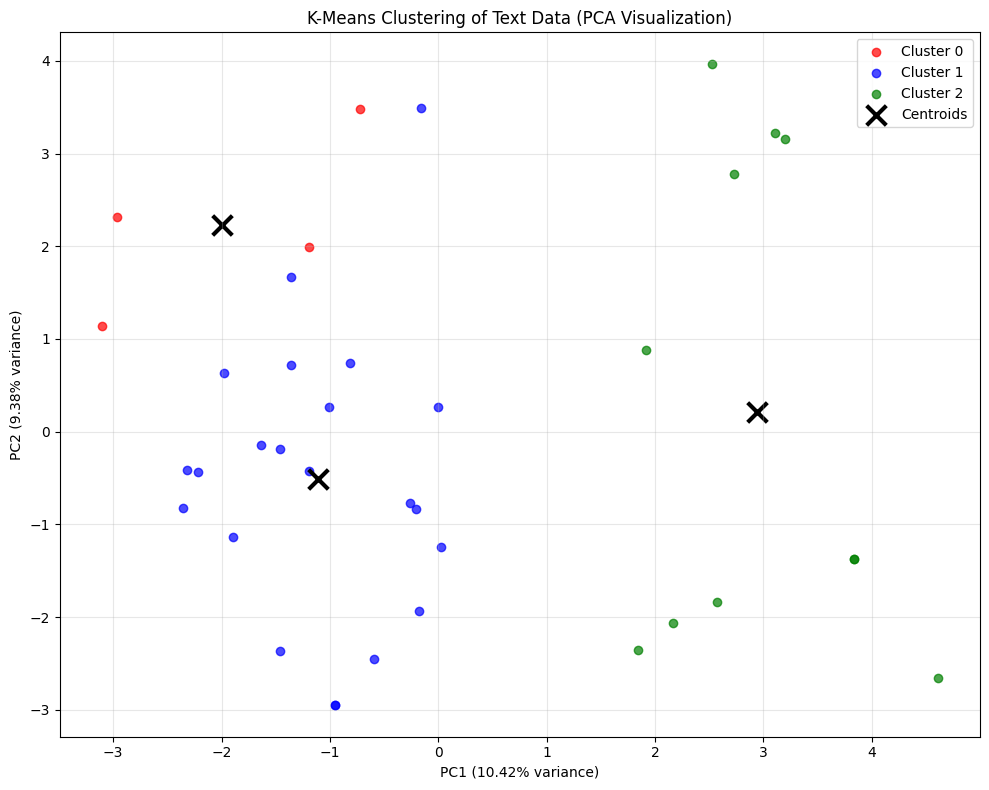

In [24]:
# Initialize and fit the classifier
classifier = TextKMeansClassifier(n_clusters=3)

classifier.fit(sample_texts)
    
# Get cluster information
cluster_info = classifier.get_cluster_info()
print("\nCluster Information:")
for cluster, info in cluster_info.items():
    print(f"\n{cluster} (Size: {info['total_texts']}):")
    for text in info['texts']:
        print(f"  - {text}")
    
# Test prediction on new texts
# new_texts = [
#     "I want to learn about neural networks",
#     "The mountains look amazing today",
#     "Should I invest in tech stocks?"
# ]
    
predictions = classifier.predict(sample_texts)
print(f"\nPredictions for new texts:")
for text, pred in zip(sample_texts, predictions):
    print(f"'{text}' -> Cluster {pred}")

# Calculate metrics
metrics = classifier.calculate_metrics()
print(f"\nClustering Metrics:")
print(f"Silhouette Score: {metrics['silhouette_score']:.3f}")
print(f"Inertia: {metrics['inertia']:.2f}")
    
# Visualize clusters
classifier.visualize_clusters()